# Importe as bibliotecas

In [32]:
# Instalar as dependências
!pip install plotly
!pip install keras

In [24]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.utils.data as data
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import streamlit as st
import pandas as pd
import plotly.express as px

# Dataset

Baixar o dataset

In [1]:
# Baixar o dataset
from torchvision import datasets
from torchvision import transforms

# Se o download falhar, tente novamente
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37313401.40it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1949148.71it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13533716.23it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2935818.89it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [21]:
#Definir os conjuntos de dados
'''Separei meus conjuntos de dados em três partes: 80% para treinamento, 10% para validação e 10% para teste. Esta foi a configuração inicial.'''

total_size = len(train_val_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = len(test_dataset)

# Ajustar as proporções
remaining_size = total_size - train_size
val_size = int(0.5 * remaining_size)
train_size = total_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])


Visualizar o dataset

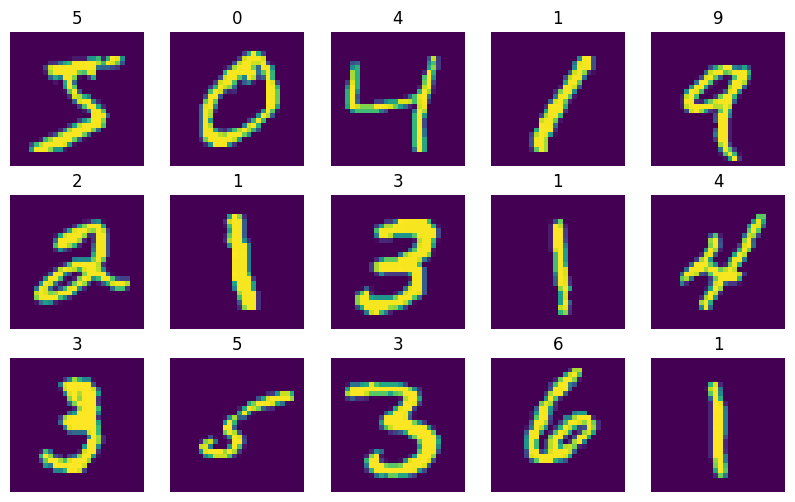

In [10]:
ROWS, COLS = 3, 5

fig, axs = plt.subplots(ROWS, COLS, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
    img, label = train_val_dataset[i]
    ax.imshow(img.numpy()[0])
    ax.set_title(label)
    ax.axis('off')

# Construa uma arquitetura de rede convolucional
Construa uma rede neural convolucional (CNN).

## LeNet

In [37]:
#Portabilidade para CUDA e CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tratamento dos dados
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Criar DataLoader para treino, validação e teste com batch size maior
batch_size = 32 #Ajustar para controlar velocidade do treinamento e precisão. Quanto menor, mais rápido, quanto maior, mais preciso (em teoria)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Converter DataLoader do PyTorch para utilizar o Numpy
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch in dataloader:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Converter dados de treino, validação e teste
x_train, y_train = dataloader_to_numpy(train_loader)
x_val, y_val = dataloader_to_numpy(val_loader)
x_test, y_test = dataloader_to_numpy(test_loader)

# Redimensionar e normalizar os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# One-hot encoding dos rótulos
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Implementação da arquitetura LeNet
model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilação do modelo
optimizer = Adam(learning_rate=0.001)  # Taxa de aprendizado ajustada para LeNet
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks para early stopping e redução da taxa de aprendizado
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Treino do Modelo
epochs = 10  # Número de épocas
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

# Teste do Modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
1688/1688 [==============================] - 41s 24ms/step - loss: 0.2053 - accuracy: 0.9379 - val_loss: 0.0875 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0687 - accuracy: 0.9785 - val_loss: 0.0502 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 27s 16ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0458 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0392 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.0403 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 29s 17ms/step - loss: 0.0271 - accuracy: 0.9910 - val_loss: 0.0433 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 7/10
1688/1688 [========================

In [38]:
# Conversão do histórico de treinamento para um DataFrame do Pandas
history_df = pd.DataFrame(history.history)

# Adicionar coluna para as épocas no Dataframe
history_df['epoch'] = history_df.index + 1

# Plotar a taxa de erro (perda) do treinamento e validação
fig_loss = px.line(history_df, x='epoch', y=['loss', 'val_loss'],
                   labels={'value': 'Loss', 'variable': 'Dataset', 'epoch': 'Epoch'},
                   title='Training and Validation Loss')
fig_loss.show()

# Plotar a acurácia do treinamento e validação
fig_accuracy = px.line(history_df, x='epoch', y=['accuracy', 'val_accuracy'],
                       labels={'value': 'Accuracy', 'variable': 'Dataset', 'epoch': 'Epoch'},
                       title='Training and Validation Accuracy')
fig_accuracy.show()


In [39]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import numpy as np

# Fazer predições no conjunto de teste
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
fig_conf_matrix = go.Figure(data=go.Heatmap(
                   z=conf_matrix,
                   x=[i for i in range(10)],
                   y=[i for i in range(10)],
                   hoverongaps=False,
                   colorscale='Blues'))

fig_conf_matrix.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='True Label')
)

fig_conf_matrix.show()


313/313 [==============================] - 2s 6ms/step


## AlexNet

In [40]:
#Portabilidade para CUDA e CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tratamento dos dados
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Criar DataLoader para treino, validação e teste com batch size maior
batch_size = 32 #Ajustar para controlar velocidade do treinamento e precisão. Quanto menor, mais rápido, quanto maior, mais preciso (em teoria)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Converter DataLoader do PyTorch para utilizar o Numpy
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch in dataloader:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Converter dados de treino, validação e teste
x_train, y_train = dataloader_to_numpy(train_loader)
x_val, y_val = dataloader_to_numpy(val_loader)
x_test, y_test = dataloader_to_numpy(test_loader)

# Redimensionar e normalizar os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# One-hot encoding dos rótulos
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Implementação da arquitetura LeNet
model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilação do modelo
optimizer = Adam(learning_rate=0.001)  # Taxa de aprendizado ajustada para LeNet
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks para early stopping e redução da taxa de aprendizado
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Treino do Modelo
epochs = 10  # Número de épocas
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

# Teste do Modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
1688/1688 [==============================] - 29s 17ms/step - loss: 0.2170 - accuracy: 0.9332 - val_loss: 0.0848 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 29s 17ms/step - loss: 0.0740 - accuracy: 0.9769 - val_loss: 0.0731 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 29s 17ms/step - loss: 0.0537 - accuracy: 0.9831 - val_loss: 0.0581 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 27s 16ms/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0602 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 28s 16ms/step - loss: 0.0353 - accuracy: 0.9885 - val_loss: 0.0459 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0282 - accuracy: 0.9910 - val_loss: 0.0476 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 7/10
1688/1688 [========================

In [41]:
# Convertendo o histórico de treinamento para um DataFrame do Pandas
history_df = pd.DataFrame(history.history)

# Adicionando uma coluna para as épocas
history_df['epoch'] = history_df.index + 1

# Plotando a taxa de erro (perda) do treinamento e validação
fig_loss = px.line(history_df, x='epoch', y=['loss', 'val_loss'],
                   labels={'value': 'Loss', 'variable': 'Dataset', 'epoch': 'Epoch'},
                   title='Training and Validation Loss')
fig_loss.show()

# Plotando a acurácia do treinamento e validação
fig_accuracy = px.line(history_df, x='epoch', y=['accuracy', 'val_accuracy'],
                       labels={'value': 'Accuracy', 'variable': 'Dataset', 'epoch': 'Epoch'},
                       title='Training and Validation Accuracy')
fig_accuracy.show()

In [42]:
# Fazer predições no conjunto de teste
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
fig_conf_matrix = go.Figure(data=go.Heatmap(
                   z=conf_matrix,
                   x=[i for i in range(10)],
                   y=[i for i in range(10)],
                   hoverongaps=False,
                   colorscale='Blues'))

fig_conf_matrix.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='True Label')
)

fig_conf_matrix.show()

313/313 [==============================] - 3s 8ms/step


# Conclusões
Descreva as suas conclusões.

## LeNet

O modelo LeNet apresenta uma queda consistente da taxa de erros ao longo do treinamento, o que pode indicar que o treinamento está sendo efetivo. Como a taxa de acurácia de validação é muito próxima da taxa de acurácia de treinamento, podemos concluir que a chance de ser overfitting é muito baixa. Além disso, podemos reparar que as últimas épocas apresentam uma estabilização, o que reforça o pensamento de que não ocorreu overfitting.
A matriz de confusão mostra que a maioria das classificações são corretas. Além disso, poucos erros de classificação são observados, indicando que o modelo tem uma alta taxa de acerto.

## AlexNet

Semelhantemente ao LeNet,  apresenta uma queda consistente da taxa de erros ao longo do treinamento, o que pode indicar que o treinamento está sendo efetivo. Como a taxa de acurácia de validação é muito próxima da taxa de acurácia de treinamento, podemos concluir que a chance de ser overfitting é muito baixa. Assim sendo, podemos ver que a generalização dos dois modelos está boa.
Analisando sua matriz de confusão, podemos ver que poucos erros de classificação são observados, indicando que o modelo tem uma alta taxa de acerto, embora ligeiramente inferior ao LeNet.

## Conclusão Final

Podemos pensar que a complexidade do AlexNet dificulta o treinamento para o conjunto utilizado. Neste caso, utilizando esta estrutura, o modelo mais adequado é o LeNet. Ambos apresentaram um bom desempenho, mas o AlexNet deixa a sugerir que resultados melhores podem ser obtidos com ajustes nos hiperparâmetros.
